#### This is an deprecated notebook. I tried creating my own measure of career preparedness. This was due to a misunderstanding with the instructions. Luckily, I can still use a lot of the work for some additional insights in the main analysis.

### Measuring Career Preparedness

**How do we measure career preparedness?**

Career preparedness exists as a latent dimension within the response data. We can't expect any one statement to capture the complete scope/nuance of the concept. Preparedness is driven by complex psychological and structural factors. We therefore expect that individuals with high preparedness to share similar response patterns across a range of statements, capturing multiple aspects of readiness for professional advancement. 

The choice on which statements to form a composite measure of preparedness should be determined by balancing theoretically-informed item selection with statistical analysis on observed response correlations and validation techniques for chosen constructs.

We should be mindful of the following:
- use an overall measure of preparedness with caution, noting the complexity of the concept, while balancing the usefulness of an broad-based measure
- separate implicit vs. explicit response variables for separate measures, to enable specificity in later analysis
- consider multiple formulations of preparedness for psychological vs. structural reasons, in addition to an broad based measure
- implement robustness checks to account for these potential limitations

The challenge of effective construct development is not new, nor unique to our analytical situation, so we'll draw on existing methodological studies to inform an effective approach, drawing from established social science literature. 

**Methodological Sources:**
- [Clark and Watson (2020)](https://pmc.ncbi.nlm.nih.gov/articles/PMC6754793/) - "Constructing Validity: New Development in Creating Objective Measuring Instruments" 
    - **Extensive Theoretical Foundation**
- [Knetka et al. (2019)](https://www.lifescied.org/doi/10.1187/cbe.18-04-0064) - "One Size Doesn't Fit All: Using Factor Analysis to Gather Validity Evidence When Using Surveys in Your Research."
    - **Validation Focus**
- [Boateng et al. (2018)](https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2018.00149/full) - "Best Practices for Developing and Valdiating Scales for Health, Social, and Behavioral Research: A Primer" 
    - **Applied Pipeline Focus**

From Boateng et al. (2018):

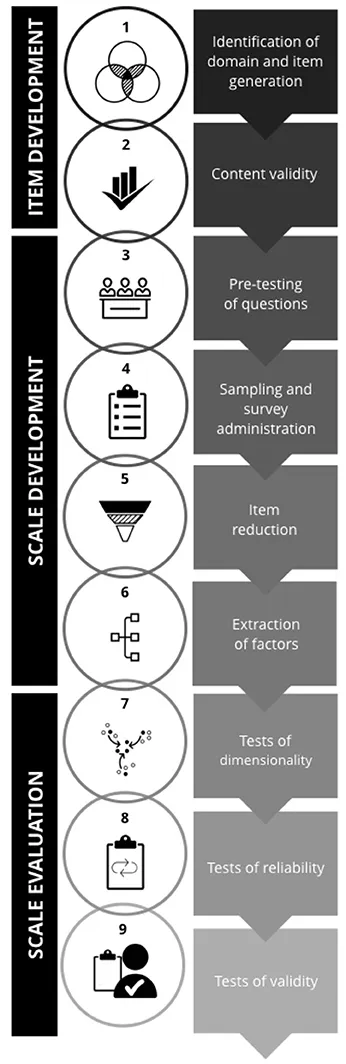

#### Methodology Brainstorming

Boateng et al. (2018) outline the phases of scale development in behavioral research. Of these, steps 5 to step 9 are most relevant for our context and detail a strategy to create an useful, verifiable measure. 

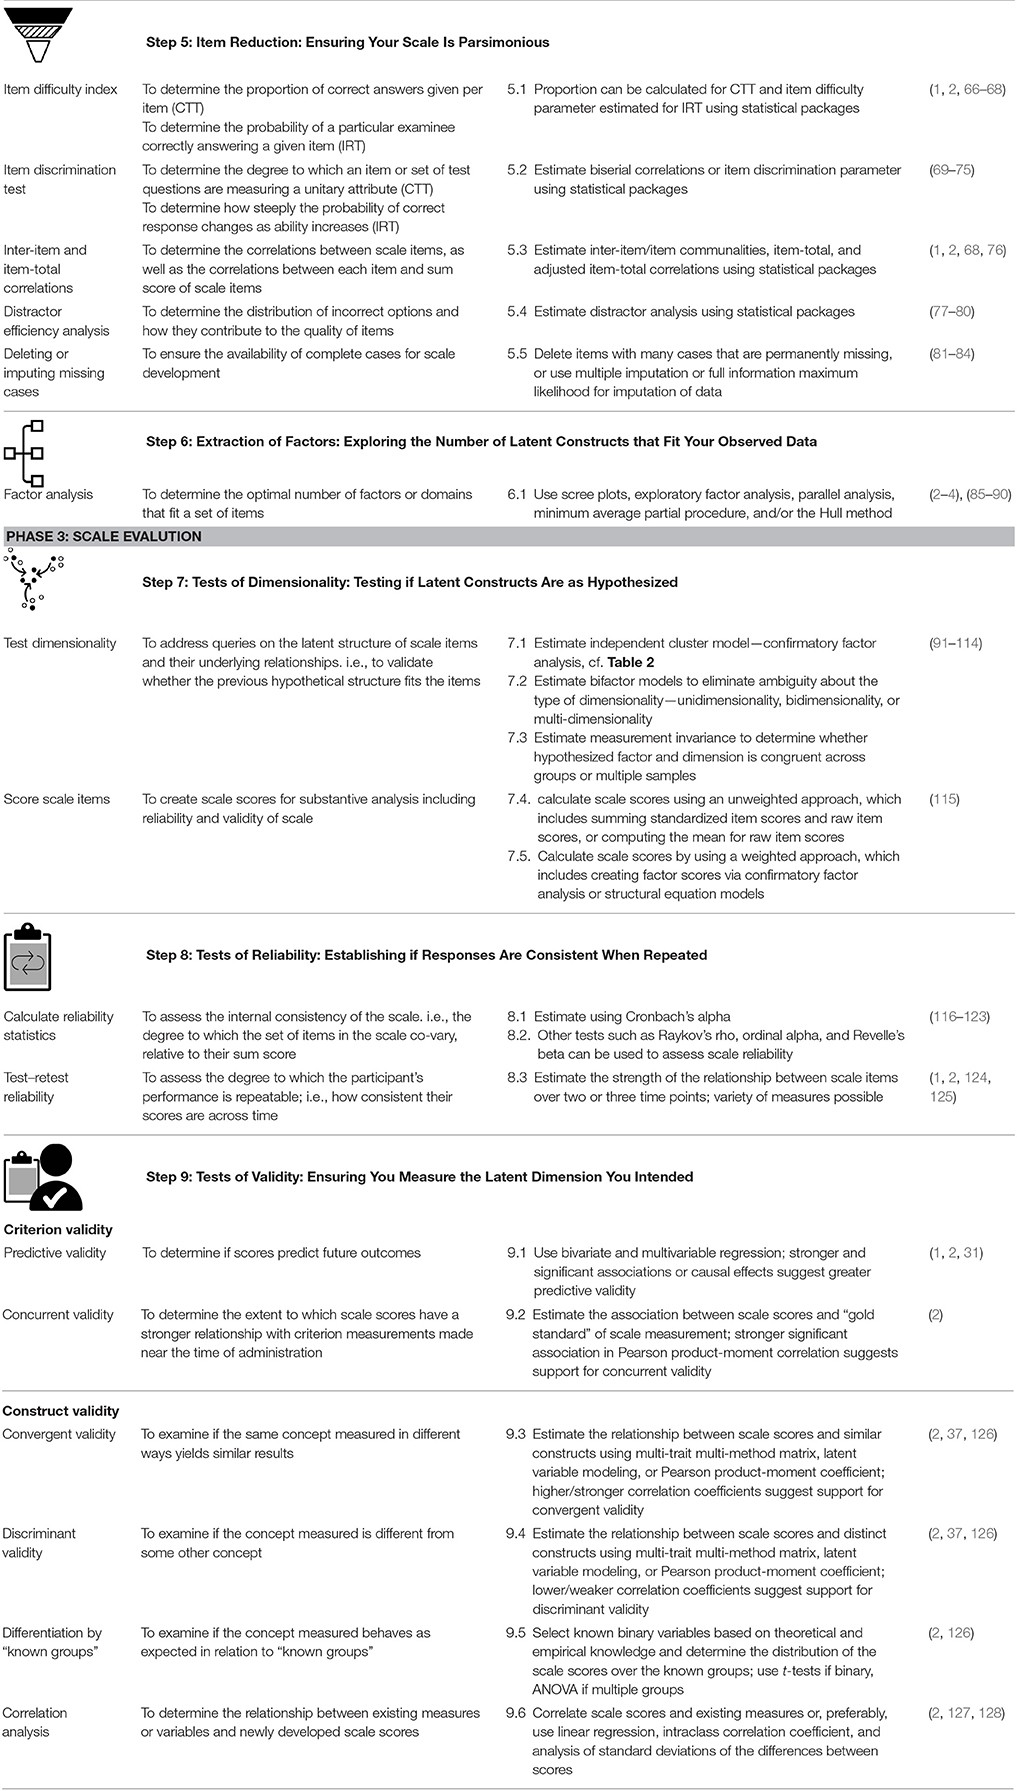

While this is a comprehensive framework, not every step is necessary for our purposes. We will be aware of its granularity, but listen to our data to create a practical yet effective solution.

Our approach will be based on exploratory factor analysis (EFA) alongside confirmatory factor analysis (CFA) for measurement validation.

It is possible to use PCA for this task, but PCA does not assume an underlying psychological construct. Whereas in EFA, the variance the items share is assumed to represent the construct and the nonshared variance is assumed to represent measurement errors (Knetka et al. 2019). EFA tries to extract only the shared variance between responses, rather than extracting the maximum variance in the data.

This makes it explicitly suited to the task of latent social measurement.

#### Step 1: Item Reduction

Which survey items are actually measuring distinct, meaningful constructs vs. which ones are redundant, unclear or not contributing much?

We want to keep the questions that clearly measure different aspects of preparedness while removing questions that either:
- Don't measure anything clearly
- Measure the same thing as other questions
- Are confusing to respondents

Does our data require item reduction? Should we perform any theoretical selection? Filtering before our factor analysis.

We might firstly check the Kaiser-Meyer-Olkin (KMR) measure of sampling adequacy. This is essentially of measure of how correlated our variables are. We are looking for a high value close to 1 which indicates high correlation between related variables, but not too much multicollinearity, and an effective sample size.  

In [66]:
# KMO Analysis
import pandas as pd
from factor_analyzer import calculate_kmo

data = pd.read_pickle("../data/survey_data_cleaned.pkl")

def get_kmo(variables, name):
    df_clean = data[variables].dropna()
    kmo_all, kmo_model = calculate_kmo(df_clean.values.astype(float))
    print(f"{name}: KMO = {kmo_model:.3f}")
    return kmo_model

# Variable groups
emotional_vars = [col for col in data.columns if col.startswith(('es_', 'el_'))]
workplace_vars = [col for col in data.columns if col.startswith(('wfs_', 'wfl_'))]
latent_vars = [col for col in data.columns if col.startswith(('es_', 'wfs_'))]
explicit_vars = [col for col in data.columns if col.startswith(('el_', 'wfl_'))]

# Calculate KMO
print("KMO Results:")
get_kmo(emotional_vars, "Emotional")
get_kmo(workplace_vars, "Workplace") 
get_kmo(latent_vars, "Latent (Fast Choice)")
get_kmo(explicit_vars, "Explicit (Likert)")

KMO Results:
Emotional: KMO = 0.944
Workplace: KMO = 0.880
Latent (Fast Choice): KMO = 0.911
Explicit (Likert): KMO = 0.942


np.float64(0.9423894439660425)

Given these fairly excellent KMO results, we don't want to reduce our items at all, as this may reduce meaningful information provide by our excellent survey results. Hence, we're ready for factor analysis.

#### Step 2: Extraction of Factors

Here we'll select factor variables, standardize our data, apply kaiser criterion, create scree plots and extract final factors.

But firstly, we should just look at what the data can tell us. 

Let's look at the correlation matrix for our two categories of responses: fast-choice and likert. 

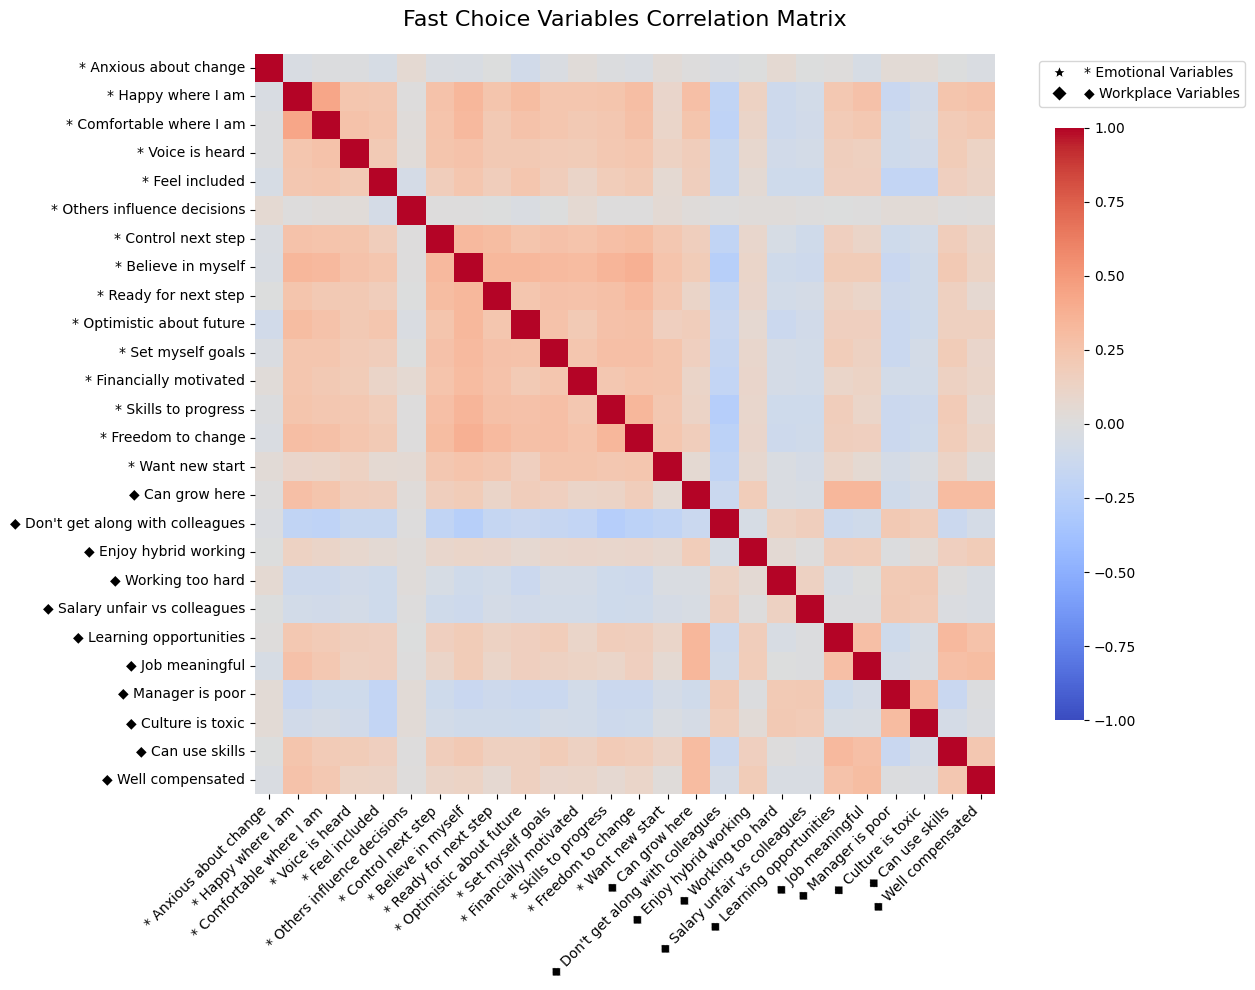

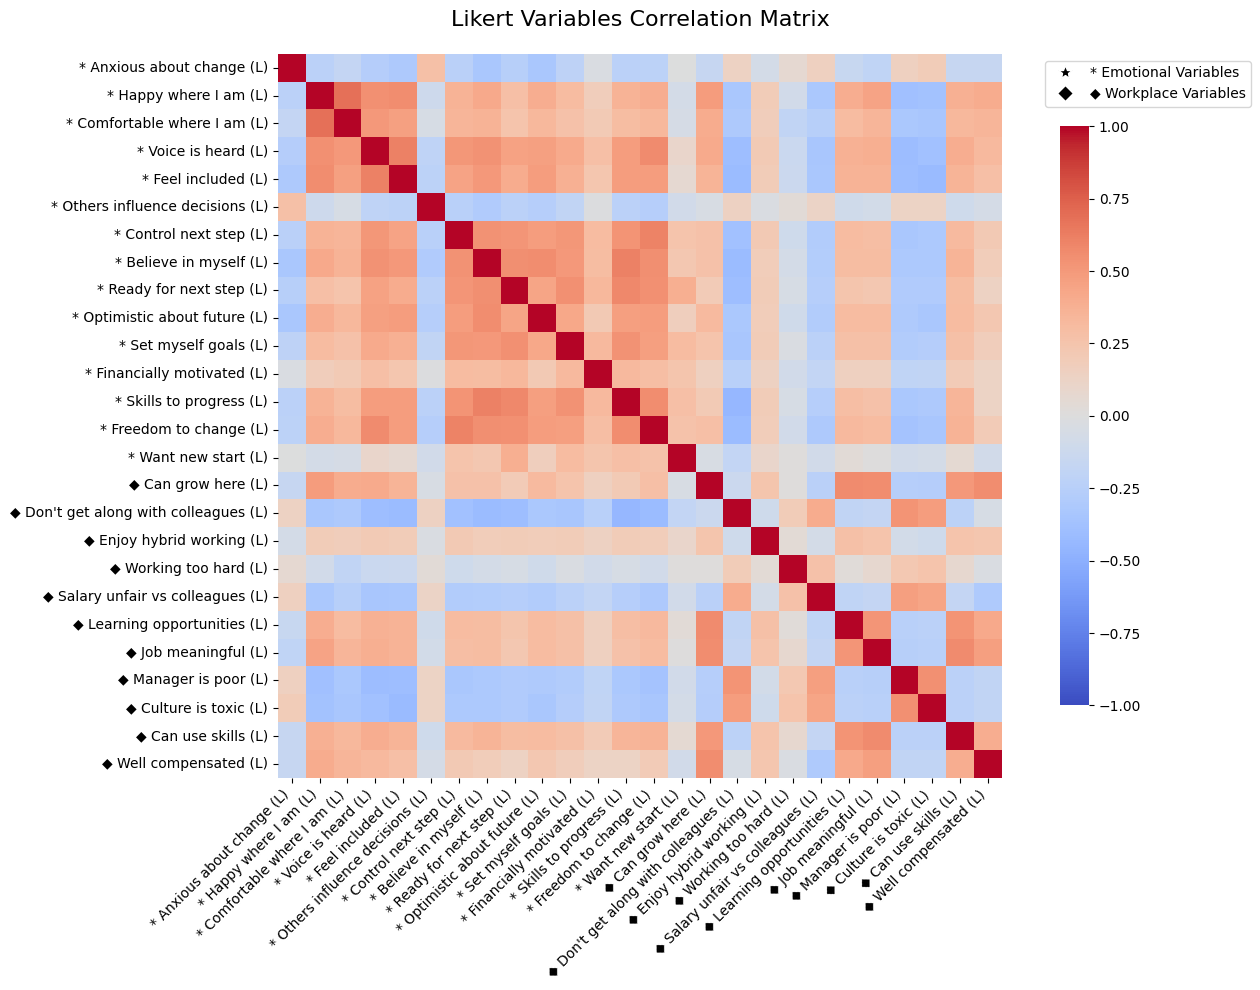

In [26]:
# Create informative variable name mappings from codebook with symbols
emotional_names = {
    'es_fgen': '* Ready for next step',
    'es_ftra_des': '* Want new start', 
    'es_ftra_aut': '* Freedom to change',
    'es_fcnt_com': '* Comfortable where I am',
    'es_fcnt_psy': '* Voice is heard',
    'es_fcon_soc': '* Others influence decisions',
    'es_fbal_anx': '* Anxious about change',
    'es_fres_fin': '* Financially motivated',
    'es_fcont_imp': '* Believe in myself',
    'es_fjou_opt': '* Optimistic about future',
    'es_fcon_inc': '* Feel included',
    'es_fbal_sat': '* Happy where I am',
    'es_fres_ski': '* Skills to progress',
    'es_fcont_con': '* Control next step',
    'es_fjou_pro': '* Set myself goals',
    'el_lgen': '* Ready for next step (L)',
    'el_ltra_des': '* Want new start (L)',
    'el_ltra_aut': '* Freedom to change (L)', 
    'el_lcnt_com': '* Comfortable where I am (L)',
    'el_lcnt_psy': '* Voice is heard (L)',
    'el_lcon_soc': '* Others influence decisions (L)',
    'el_lbal_anx': '* Anxious about change (L)',
    'el_lres_fin': '* Financially motivated (L)',
    'el_lcont_imp': '* Believe in myself (L)',
    'el_ljou_opt': '* Optimistic about future (L)',
    'el_lcon_inc': '* Feel included (L)',
    'el_lbal_sat': '* Happy where I am (L)',
    'el_lres_ski': '* Skills to progress (L)',
    'el_lcont_con': '* Control next step (L)',
    'el_ljou_pro': '* Set myself goals (L)'
}

workplace_names = {
    'wfs_fuse_skills': '◆ Can use skills',
    'wfs_flearn_dev': '◆ Learning opportunities',
    'wfs_fcarprom': '◆ Can grow here',
    'wfs_fmean_full': '◆ Job meaningful',
    'wfs_fpoorman': '◆ Manager is poor',
    'wfs_ftoxic': '◆ Culture is toxic',
    'wfs_fexcess_wk': '◆ Working too hard',
    'wfs_fcollea': '◆ Don\'t get along with colleagues',
    'wfs_fwellcomp': '◆ Well compensated',
    'wfs_ffin_fair': '◆ Salary unfair vs colleagues',
    'wfs_fenjhyb': '◆ Enjoy hybrid working',
    'wfl_luse_skills': '◆ Can use skills (L)',
    'wfl_llearn_dev': '◆ Learning opportunities (L)',
    'wfl_lcarprom_d': '◆ Can grow here (L)',
    'wfl_lmean_full': '◆ Job meaningful (L)',
    'wfl_lpoorman': '◆ Manager is poor (L)',
    'wfl_ltoxic': '◆ Culture is toxic (L)',
    'wfl_lexcess_wk': '◆ Working too hard (L)',
    'wfl_lcollea': '◆ Don\'t get along with colleagues (L)',
    'wfl_lwellcomp': '◆ Well compensated (L)',
    'wfl_lfin_lair': '◆ Salary unfair vs colleagues (L)',
    'wfl_lenjhyb': '◆ Enjoy hybrid working (L)'
}

# Get variable lists
fast_choice_vars = [col for col in data.columns if col.startswith(('es_', 'wfs_'))]
likert_vars = [col for col in data.columns if col.startswith(('el_', 'wfl_'))]

# Calculate correlations
fast_choice_corr = data[fast_choice_vars].corr()
likert_corr = data[likert_vars].corr()

# Create combined name mapping
all_names = {**emotional_names, **workplace_names}

# Rename correlation matrix indices and columns
fast_choice_corr_renamed = fast_choice_corr.rename(index=all_names, columns=all_names)
likert_corr_renamed = likert_corr.rename(index=all_names, columns=all_names)

import seaborn as sns
import matplotlib.pyplot as plt

# Create color coding for variable types
def add_variable_type_colors(ax, var_names, var_list):
    """Add colored bars to distinguish emotional vs workplace variables"""
    colors = []
    for var in var_list:
        if var.startswith(('es_', 'el_')):
            colors.append('#FF6B6B')  # Red for emotional
        else:
            colors.append('#4ECDC4')  # Teal for workplace
    
    # Add colored bar on left side
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((-0.1, i), 0.1, 1, color=color, clip_on=False))
    
    # Add colored bar on bottom
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, -0.1), 1, 0.1, color=color, clip_on=False))

# Fast choice correlation matrix
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(fast_choice_corr_renamed, annot=False, cmap="coolwarm", square=True, 
           cbar_kws={"shrink": .8}, vmin=-1, vmax=1, ax=ax)
ax.set_title("Fast Choice Variables Correlation Matrix", fontsize=16, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', 
                             markersize=10, label='* Emotional Variables'),
                  plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='black', 
                            markersize=8, label='◆ Workplace Variables')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Likert correlation matrix  
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(likert_corr_renamed, annot=False, cmap="coolwarm", square=True,
           cbar_kws={"shrink": .8}, vmin=-1, vmax=1, ax=ax)
ax.set_title("Likert Variables Correlation Matrix", fontsize=16, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', 
                             markersize=10, label='* Emotional Variables'),
                  plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='black', 
                            markersize=8, label='◆ Workplace Variables')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

Immediately we can see some very clear patterns.

Fast Choice Vars:
- Correlations are not as strong comparatively
- Covariance among subset of emotional variables, specifically those related to believing in one's self and future planning
- Some very logical correlations, between 'can grow here' and 'learning opportunities/job meaningful'
- Some clear groupings, it would make sense that there's latent factors explaining our variance
- Emotional vars tend to co-vary, as do Workplace/Functional, but covariance between the two is less common 

Likert Variables:
- Stronger correlations in general, especially within the emotional/workplace groupings
- A lot less gray, implies that likert responses are just more extreme (i.e. perhaps people are more decisive when they have time to think about their answers)

Interestingly, in both, some questions just don't correlate much at all.

What about correlations with "Ready for next step"

Fast choice:
- Positive: Believe in myself, In control of next step, freedom to change etc.
- Negative: Anxious about change, others influence financial decisions, 

Likert:
- Positive: Set myself goals, freedom to change, skills to progress, can use skills
- Negative: Anxious about change, others influence decisions, don't get along with colleagues, salary unfair, manager poor/toxic 

We can really start to see why a factor analysis is beneficial for our data. There's a lot of variables and variance patterns to sort through. A manually encoding approach would probably introduce a lot of measurement error. Likewise, it's very plausible that our factor analysis would pick up a real 'latent factors'.

##### Now let's proceed onto the factor analysis.

Need to evaluate:
1) factor loading - how high the correlation between the variable and the factor
2) eigenvalue - how much variance can be explained by the factor of all variables
3) communality - how much variance of the total variables can be explained by the factors 

To do the above, we need the communalities and the factor component matrix.

Fast choice variables: 26
Likert variables: 26
FACTOR ANALYSIS

Fast Choice Variables - Sample size after removing missing: 4194
Bartlett's test: Chi-square = 16505.25, p-value = 0.0000
KMO test: 0.911


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


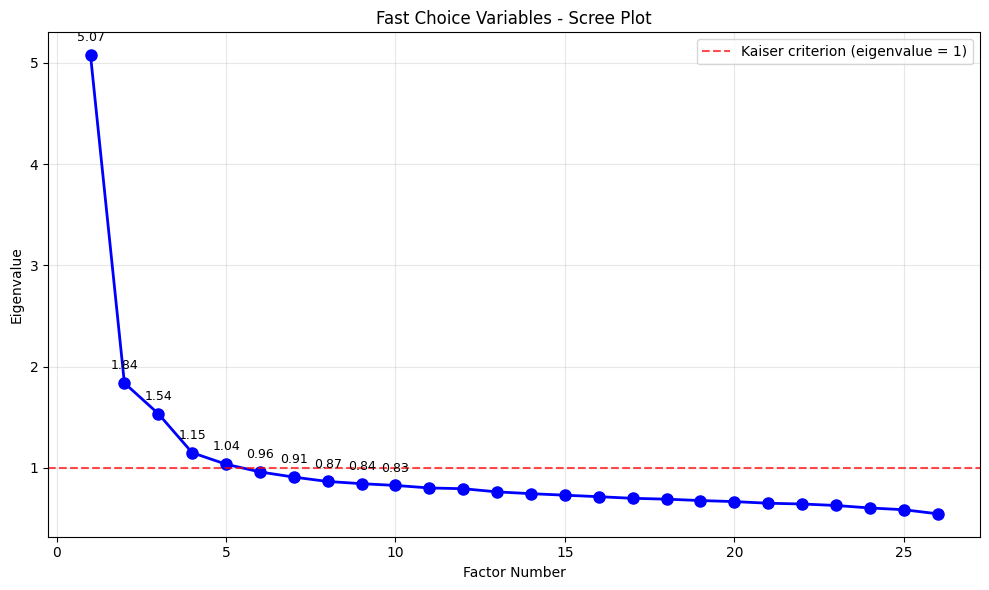

Number of factors (Kaiser criterion): 5
Factors explaining 60% variance: 11
Factors explaining 70% variance: 15
First 5 factors explain: 40.9% of variance

Using 5 factors for analysis

=== Fast Choice Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 5.075 | 19.5% of total | 47.7% of extracted | 47.7% cumulative
Factor 2: 1.838 | 7.1% of total | 17.3% of extracted | 65.0% cumulative
Factor 3: 1.536 | 5.9% of total | 14.4% of extracted | 79.4% cumulative
Factor 4: 1.150 | 4.4% of total | 10.8% of extracted | 90.3% cumulative
Factor 5: 1.036 | 4.0% of total | 9.7% of extracted | 100.0% cumulative

Factor Loadings Matrix:


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


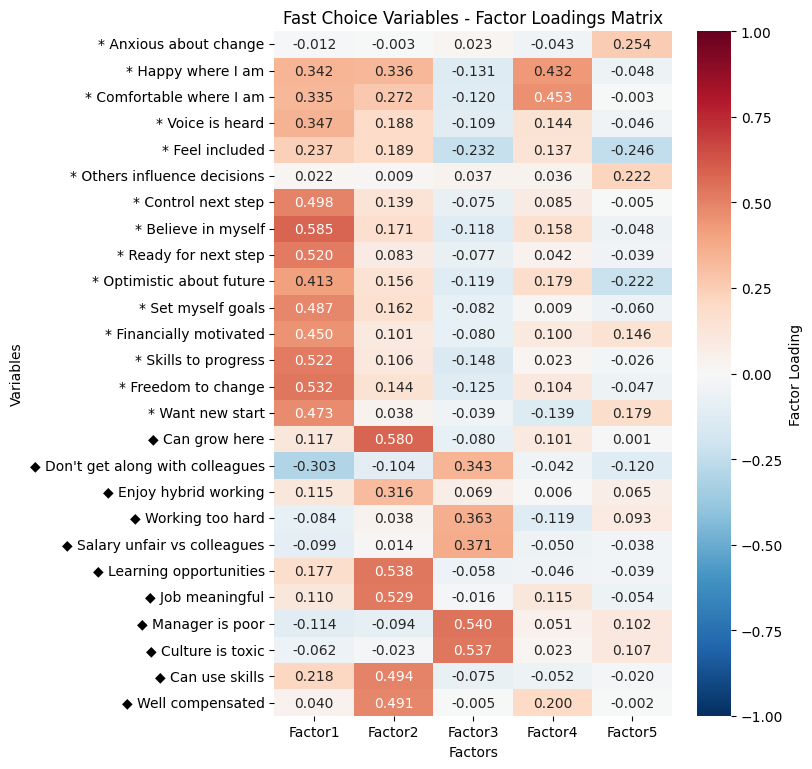


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Happy where I am                     0.435
* Believe in myself                    0.413
* Comfortable where I am               0.406
◆ Can grow here                        0.366
* Freedom to change                    0.333
◆ Learning opportunities               0.327
◆ Manager is poor                      0.326
◆ Job meaningful                       0.308
* Skills to progress                   0.306
◆ Culture is toxic                     0.304
◆ Can use skills                       0.301
* Optimistic about future              0.291
* Ready for next step                  0.287
◆ Well compensated                     0.283
* Control next step                    0.280
* Want new start                       0.278
* Set myself goals                     0.274
* Financially motivated                0.250
◆ Don't get along with colleagues      0.237
* Feel included

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


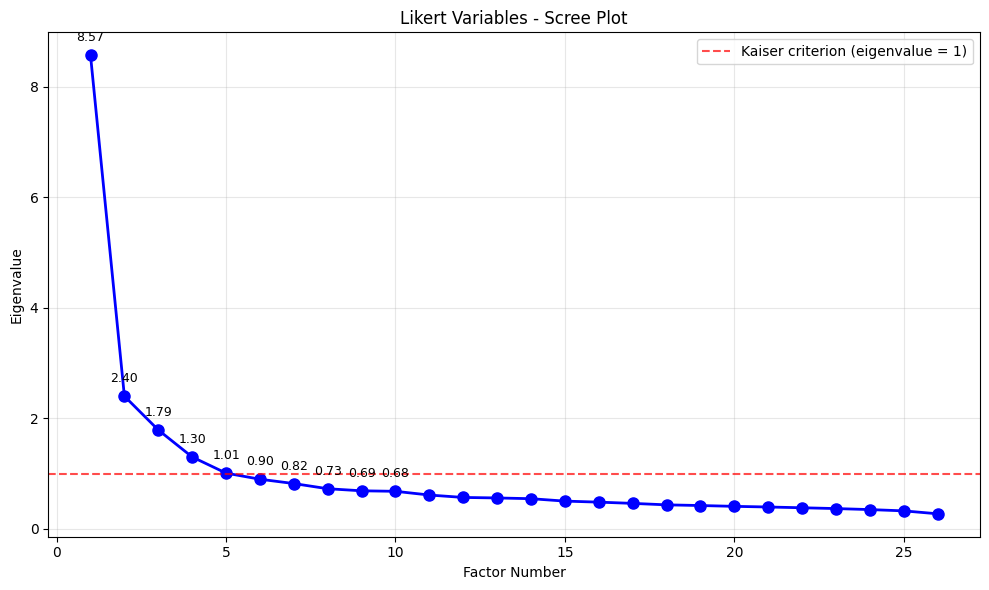

Number of factors (Kaiser criterion): 5
Factors explaining 60% variance: 6
Factors explaining 70% variance: 9
First 5 factors explain: 58.0% of variance

Using 5 factors for analysis

=== Likert Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 8.570 | 33.0% of total | 56.9% of extracted | 56.9% cumulative
Factor 2: 2.402 | 9.2% of total | 15.9% of extracted | 72.8% cumulative
Factor 3: 1.790 | 6.9% of total | 11.9% of extracted | 84.7% cumulative
Factor 4: 1.302 | 5.0% of total | 8.6% of extracted | 93.3% cumulative
Factor 5: 1.010 | 3.9% of total | 6.7% of extracted | 100.0% cumulative

Factor Loadings Matrix:


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


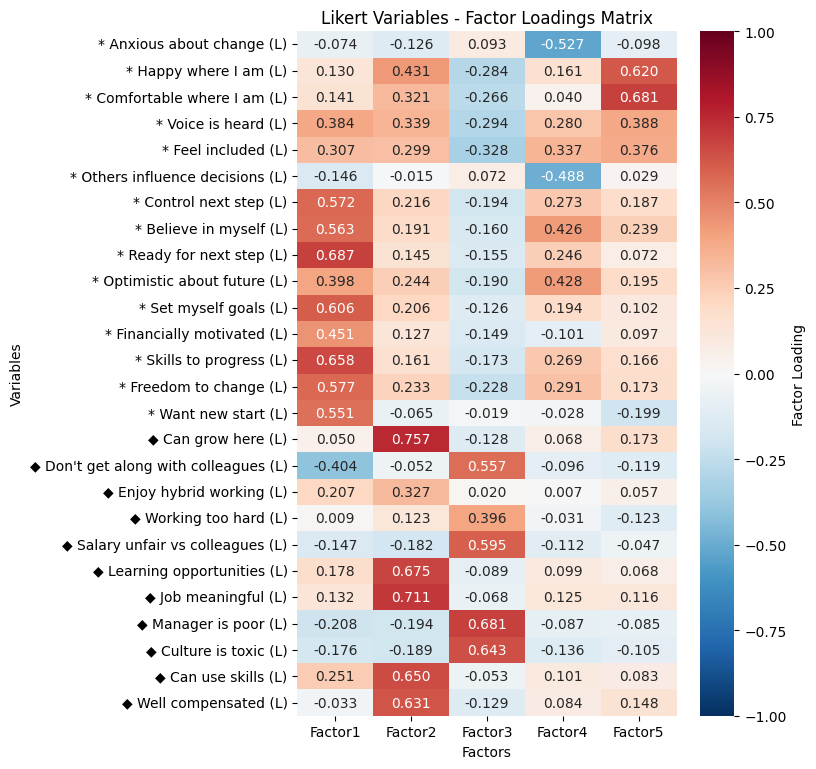


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Happy where I am (L)                 0.694
* Comfortable where I am (L)           0.659
◆ Can grow here (L)                    0.627
* Believe in myself (L)                0.619
* Skills to progress (L)               0.590
* Ready for next step (L)              0.582
* Voice is heard (L)                   0.578
◆ Manager is poor (L)                  0.559
◆ Job meaningful (L)                   0.556
* Freedom to change (L)                0.553
* Feel included (L)                    0.546
* Control next step (L)                0.521
◆ Learning opportunities (L)           0.510
◆ Culture is toxic (L)                 0.509
◆ Can use skills (L)                   0.505
◆ Don't get along with colleagues...    0.500
* Optimistic about future (L)          0.475
* Set myself goals (L)                 0.474
◆ Well compensated (L)                 0.444
◆ Salary unfai

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy.stats import bartlett
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Variable name mappings from your code
emotional_names = {
    'es_fgen': '* Ready for next step',
    'es_ftra_des': '* Want new start', 
    'es_ftra_aut': '* Freedom to change',
    'es_fcnt_com': '* Comfortable where I am',
    'es_fcnt_psy': '* Voice is heard',
    'es_fcon_soc': '* Others influence decisions',
    'es_fbal_anx': '* Anxious about change',
    'es_fres_fin': '* Financially motivated',
    'es_fcont_imp': '* Believe in myself',
    'es_fjou_opt': '* Optimistic about future',
    'es_fcon_inc': '* Feel included',
    'es_fbal_sat': '* Happy where I am',
    'es_fres_ski': '* Skills to progress',
    'es_fcont_con': '* Control next step',
    'es_fjou_pro': '* Set myself goals',
    'el_lgen': '* Ready for next step (L)',
    'el_ltra_des': '* Want new start (L)',
    'el_ltra_aut': '* Freedom to change (L)', 
    'el_lcnt_com': '* Comfortable where I am (L)',
    'el_lcnt_psy': '* Voice is heard (L)',
    'el_lcon_soc': '* Others influence decisions (L)',
    'el_lbal_anx': '* Anxious about change (L)',
    'el_lres_fin': '* Financially motivated (L)',
    'el_lcont_imp': '* Believe in myself (L)',
    'el_ljou_opt': '* Optimistic about future (L)',
    'el_lcon_inc': '* Feel included (L)',
    'el_lbal_sat': '* Happy where I am (L)',
    'el_lres_ski': '* Skills to progress (L)',
    'el_lcont_con': '* Control next step (L)',
    'el_ljou_pro': '* Set myself goals (L)'
}

workplace_names = {
    'wfs_fuse_skills': '◆ Can use skills',
    'wfs_flearn_dev': '◆ Learning opportunities',
    'wfs_fcarprom': '◆ Can grow here',
    'wfs_fmean_full': '◆ Job meaningful',
    'wfs_fpoorman': '◆ Manager is poor',
    'wfs_ftoxic': '◆ Culture is toxic',
    'wfs_fexcess_wk': '◆ Working too hard',
    'wfs_fcollea': '◆ Don\'t get along with colleagues',
    'wfs_fwellcomp': '◆ Well compensated',
    'wfs_ffin_fair': '◆ Salary unfair vs colleagues',
    'wfs_fenjhyb': '◆ Enjoy hybrid working',
    'wfl_luse_skills': '◆ Can use skills (L)',
    'wfl_llearn_dev': '◆ Learning opportunities (L)',
    'wfl_lcarprom_d': '◆ Can grow here (L)',
    'wfl_lmean_full': '◆ Job meaningful (L)',
    'wfl_lpoorman': '◆ Manager is poor (L)',
    'wfl_ltoxic': '◆ Culture is toxic (L)',
    'wfl_lexcess_wk': '◆ Working too hard (L)',
    'wfl_lcollea': '◆ Don\'t get along with colleagues (L)',
    'wfl_lwellcomp': '◆ Well compensated (L)',
    'wfl_lfin_lair': '◆ Salary unfair vs colleagues (L)',
    'wfl_lenjhyb': '◆ Enjoy hybrid working (L)'
}

# Combine mappings
all_names = {**emotional_names, **workplace_names}

# Get variable lists from your existing code
fast_choice_vars = [col for col in data.columns if col.startswith(('es_', 'wfs_'))]
likert_vars = [col for col in data.columns if col.startswith(('el_', 'wfl_'))]

print(f"Fast choice variables: {len(fast_choice_vars)}")
print(f"Likert variables: {len(likert_vars)}")

def perform_factor_analysis(df, var_list, title_prefix):
    """Perform factor analysis with scree plot"""
    
    # Select and clean data
    fa_data = df[var_list].dropna()
    print(f"\n{title_prefix} - Sample size after removing missing: {len(fa_data)}")
    
    # Standardize data
    scaler = StandardScaler()
    fa_data_scaled = scaler.fit_transform(fa_data)
    fa_data_scaled = pd.DataFrame(fa_data_scaled, columns=var_list)
    
    # Test assumptions
    # Bartlett's test for sphericity
    chi_square_value, p_value = calculate_bartlett_sphericity(fa_data_scaled)
    print(f"Bartlett's test: Chi-square = {chi_square_value:.2f}, p-value = {p_value:.4f}")
    
    # Kaiser-Meyer-Olkin test
    kmo_all, kmo_model = calculate_kmo(fa_data_scaled)
    print(f"KMO test: {kmo_model:.3f}")
    
    # Scree plot - determine number of factors
    fa_scree = FactorAnalyzer(n_factors=len(var_list), rotation=None)
    fa_scree.fit(fa_data_scaled)
    
    # Get eigenvalues
    eigenvalues, _ = fa_scree.get_eigenvalues()
    
    # Create scree plot
    plt.figure(figsize=(10, 6))
    factors = range(1, len(eigenvalues) + 1)
    plt.plot(factors, eigenvalues, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Kaiser criterion (eigenvalue = 1)')
    plt.title(f'{title_prefix} - Scree Plot')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add eigenvalue labels
    for i, ev in enumerate(eigenvalues[:10]):  # Label first 10
        plt.annotate(f'{ev:.2f}', (i+1, ev), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Determine number of factors (Kaiser criterion: eigenvalue > 1)
    n_factors = sum(eigenvalues > 1)
    print(f"Number of factors (Kaiser criterion): {n_factors}")
    
    # Alternative: explained variance criterion (e.g., 60-70%)
    cumvar = np.cumsum(eigenvalues) / sum(eigenvalues) * 100
    n_factors_60 = sum(cumvar < 60) + 1
    n_factors_70 = sum(cumvar < 70) + 1
    
    print(f"Factors explaining 60% variance: {n_factors_60}")
    print(f"Factors explaining 70% variance: {n_factors_70}")
    print(f"First 5 factors explain: {cumvar[4]:.1f}% of variance")
    
    # Perform factor analysis with determined number of factors
    n_factors_final = max(2, min(n_factors, 5))  # Use 2-5 factors
    print(f"\nUsing {n_factors_final} factors for analysis")
    
    # Factor analysis with varimax rotation
    fa = FactorAnalyzer(n_factors=n_factors_final, rotation='varimax')
    fa.fit(fa_data_scaled)
    
    # Get results with proper variable names
    loadings = pd.DataFrame(fa.loadings_, 
                           columns=[f'Factor{i+1}' for i in range(n_factors_final)],
                           index=var_list)
    
    # Add descriptive names
    loadings['Variable_Name'] = loadings.index.map(all_names)
    loadings = loadings[['Variable_Name'] + [f'Factor{i+1}' for i in range(n_factors_final)]]
    
    communalities = pd.DataFrame({'Variable_Name': [all_names.get(var, var) for var in var_list],
                                 'Communality': fa.get_communalities()}, 
                                index=var_list)
    
    eigenvalues_final = fa.get_eigenvalues()[0][:n_factors_final]
    
    # Print results
    print(f"\n=== {title_prefix} RESULTS ===")
    print(f"\nEigenvalues and Variance Explained:")
    total_variance = sum(eigenvalues_final)
    cumulative = 0
    for i, ev in enumerate(eigenvalues_final):
        var_explained = ev / len(var_list) * 100
        prop_explained = ev / total_variance * 100
        cumulative += prop_explained
        print(f"Factor {i+1}: {ev:.3f} | {var_explained:.1f}% of total | {prop_explained:.1f}% of extracted | {cumulative:.1f}% cumulative")
    
    # Factor loadings heatmap
    print(f"\nFactor Loadings Matrix:")
    
    # Prepare data for heatmap
    loadings_heatmap = loadings.copy()
    factor_cols = [f'Factor{i+1}' for i in range(n_factors_final)]
    loadings_matrix = loadings_heatmap[factor_cols]
    
    # Create heatmap
    plt.figure(figsize=(8, max(6, len(var_list) * 0.3)))
    
    # Use RdBu_r colormap (red-white-blue reversed) for better positive/negative distinction
    sns.heatmap(loadings_matrix, 
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r', 
                center=0,
                vmin=-1, 
                vmax=1,
                cbar_kws={'label': 'Factor Loading'},
                yticklabels=[all_names.get(var, var) for var in var_list])
    
    plt.title(f'{title_prefix} - Factor Loadings Matrix')
    plt.xlabel('Factors')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()
    
    # Communalities table
    print(f"\nCommunalities (sorted by value):")
    print("=" * 50)
    comm_sorted = communalities.sort_values('Communality', ascending=False)
    print(f"{'Variable':<35} {'Communality':>10}")
    print("-" * 47)
    for idx, row in comm_sorted.iterrows():
        var_name = row['Variable_Name'][:33] + ('...' if len(row['Variable_Name']) > 33 else '')
        comm_val = row['Communality']
        print(f"{var_name:<35} {comm_val:>8.3f}")
    
    # Low communalities warning
    low_comm = communalities[communalities['Communality'] < 0.3]
    if len(low_comm) > 0:
        print(f"\n⚠️  Variables with low communalities (< 0.3) - consider removal:")
        for idx, row in low_comm.iterrows():
            print(f"   {row['Variable_Name']}: {row['Communality']:.3f}")
    else:
        print(f"\n✅ All variables have adequate communalities (≥ 0.3)")
    
    return {
        'loadings': loadings,
        'communalities': communalities,
        'eigenvalues': eigenvalues_final,
        'factor_analyzer': fa,
        'n_factors': n_factors_final
    }

# Perform factor analysis for both groups
print("="*60)
print("FACTOR ANALYSIS")
print("="*60)

# Fast choice variables
results_fast = perform_factor_analysis(data, fast_choice_vars, "Fast Choice Variables")

# Likert variables  
results_likert = perform_factor_analysis(data, likert_vars, "Likert Variables")


##### Interpreting the factors

Factor 1: Appears to capture career agency/self-efficacy - high loadings on "Ready for next step" (0.687), "Set myself goals" (0.606), "Control next step" (0.572), "Believe in myself" (0.563)

Factor 2: Looks like workplace satisfaction/growth - strong loadings on "Can grow here" (0.757), "Job meaningful" (0.711), "Learning opportunities" (0.675), "Can use skills" (0.650)

Factor 3: Represents workplace dysfunction - high loadings on "Culture is toxic" (0.643), "Manager is poor" (0.681), "Salary unfair vs colleagues" (0.595)

Factor 4: Mixed factor, harder to interpret cleanly (probably left-over variance, non correlated variables)

Factor 5: Also mixed, potentially workplace comfort but weak loadings (probably left-over variance)

A robust career preparedness measure should be:

- Multidimensional but coherent: Capture different aspects (skills, planning, adaptability, networking) that all contribute to career readiness
- Behaviorally anchored: Include concrete actions/skills, not just attitudes
- Predictively valid: Should correlate with actual career outcomes
- Developmentally oriented: Capture capacity for growth, not just current state

### Where are we at?

We need to think carefully at this point. It's tempting to just run with factor 1, but it isn't really 'career preparedness.'
Instead, we should revise our approach. We want 

### Hierarchical Factor Analysis Approach

Based on our EFA results, we'll implement a more methodologically sound two-stage approach:

**Stage 1:** Extract domain-specific factors using empirical weights within theoretically-defined domains
**Stage 2:** Combine domain factors using equal weighting based on theoretical justification

This approach separates the "what to measure" question (theory) from the "how items combine" question (empirics).

In [50]:
# Revised Stage 1: Separate Fast vs Likert Domains
emotional_readiness_fast = ['es_fgen', 'es_fcont_con', 'es_fjou_pro', 'es_fcont_imp', 'es_fres_ski']
emotional_readiness_likert = ['el_lgen', 'el_lcont_con', 'el_ljou_pro', 'el_lcont_imp', 'el_lres_ski']

workplace_opportunity_fast = ['wfs_flearn_dev', 'wfs_fcarprom', 'wfs_fuse_skills', 'wfs_fmean_full']
workplace_opportunity_likert = ['wfl_llearn_dev', 'wfl_lcarprom_d', 'wfl_luse_skills', 'wfl_lmean_full']

workplace_barriers_fast = ['wfs_fpoorman', 'wfs_ftoxic', 'wfs_ffin_fair']
workplace_barriers_likert = ['wfl_lpoorman', 'wfl_ltoxic', 'wfl_lfin_lair']

print("Domain Variables (Corrected):")
print(f"Emotional Readiness Fast: {len(emotional_readiness_fast)} items")
print(f"Emotional Readiness Likert: {len(emotional_readiness_likert)} items")
print(f"Workplace Opportunity Fast: {len(workplace_opportunity_fast)} items") 
print(f"Workplace Opportunity Likert: {len(workplace_opportunity_likert)} items")
print(f"Workplace Barriers Fast: {len(workplace_barriers_fast)} items")
print(f"Workplace Barriers Likert: {len(workplace_barriers_likert)} items")

Domain Variables (Corrected):
Emotional Readiness Fast: 5 items
Emotional Readiness Likert: 5 items
Workplace Opportunity Fast: 4 items
Workplace Opportunity Likert: 4 items
Workplace Barriers Fast: 3 items
Workplace Barriers Likert: 3 items


In [52]:
# CORRECTED Stage 2: Extract factors with proper direction validation

def extract_domain_factor_corrected(data, var_list, domain_name, key_indicator, expected_direction='positive'):
    """
    Extract factor and ensure it correlates correctly with key indicator
    
    Args:
        key_indicator: Variable that should have strongest positive relationship with construct
        expected_direction: 'positive' if higher factor = more of construct, 'negative' if reverse
    """
    domain_data = data[var_list].dropna()
    print(f"\n{domain_name}: {len(domain_data)} complete cases")
    
    # Standardize
    scaler = StandardScaler()
    domain_scaled = scaler.fit_transform(domain_data)
    
    # Single factor extraction  
    fa = FactorAnalyzer(n_factors=1, rotation=None)
    fa.fit(domain_scaled)
    
    factor_scores = fa.transform(domain_scaled)
    loadings = fa.loadings_[:, 0]
    
    # Find the key indicator's loading
    key_idx = var_list.index(key_indicator)
    key_loading = loadings[key_idx]
    
    # Ensure key indicator has positive loading (factor points in right direction)
    if key_loading < 0:
        print(f"⚠️  Reversing {domain_name} factor to align with {all_names[key_indicator]}")
        factor_scores = -factor_scores
        loadings = -loadings
    
    # Print corrected loadings
    loadings_df = pd.DataFrame({
        'Variable': [all_names.get(var, var) for var in var_list],
        'Loading': loadings
    })
    print(f"\nCorrected Factor Loadings for {domain_name}:")
    print(loadings_df.round(3))
    
    # Eigenvalue and variance explained
    eigenvalue = fa.get_eigenvalues()[0][0]
    var_explained = eigenvalue / len(var_list) * 100
    print(f"Eigenvalue: {eigenvalue:.3f}")
    print(f"Variance Explained: {var_explained:.1f}%")
    
    return factor_scores.flatten(), fa, loadings_df

# Extract corrected domain factors
emotional_fast_scores, _, _ = extract_domain_factor_corrected(
    data, emotional_readiness_fast, "Emotional Readiness (Fast)", 
    'es_fgen', 'positive'  # "Ready for next step" should correlate positively
)

emotional_likert_scores, _, _ = extract_domain_factor_corrected(
    data, emotional_readiness_likert, "Emotional Readiness (Likert)", 
    'el_lgen', 'positive'
)

opportunity_fast_scores, _, _ = extract_domain_factor_corrected(
    data, workplace_opportunity_fast, "Workplace Opportunity (Fast)",
    'wfs_flearn_dev', 'positive'  # "Learning opportunities" should correlate positively
)

opportunity_likert_scores, _, _ = extract_domain_factor_corrected(
    data, workplace_opportunity_likert, "Workplace Opportunity (Likert)",
    'wfl_llearn_dev', 'positive'
)

barriers_fast_scores, _, _ = extract_domain_factor_corrected(
    data, workplace_barriers_fast, "Workplace Barriers (Fast)",
    'wfs_fpoorman', 'positive'  # Higher loading = more barriers (we'll reverse later)
)

barriers_likert_scores, _, _ = extract_domain_factor_corrected(
    data, workplace_barriers_likert, "Workplace Barriers (Likert)", 
    'wfl_lpoorman', 'positive'
)


Emotional Readiness (Fast): 4206 complete cases
⚠️  Reversing Emotional Readiness (Fast) factor to align with * Ready for next step

Corrected Factor Loadings for Emotional Readiness (Fast):
                Variable  Loading
0  * Ready for next step    0.536
1    * Control next step    0.535
2     * Set myself goals    0.511
3    * Believe in myself    0.623
4   * Skills to progress    0.540
Eigenvalue: 2.207
Variance Explained: 44.1%

Emotional Readiness (Likert): 4211 complete cases
⚠️  Reversing Emotional Readiness (Likert) factor to align with * Ready for next step (L)

Corrected Factor Loadings for Emotional Readiness (Likert):
                    Variable  Loading
0  * Ready for next step (L)    0.747
1    * Control next step (L)    0.701
2     * Set myself goals (L)    0.699
3    * Believe in myself (L)    0.754
4   * Skills to progress (L)    0.779
Eigenvalue: 3.167
Variance Explained: 63.3%

Workplace Opportunity (Fast): 4208 complete cases
⚠️  Reversing Workplace Opportunity

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

In [59]:
# CORRECTED Stage 3: Create separate Fast and Likert measures with simplified weights

# Define simplified weighting schemes (easy to adjust)
WEIGHTING_SCHEMES = {
    'equal': {
        'emotional': 1/3,
        'opportunity': 1/3, 
        'barriers': 1/3,
        'description': 'Equal weighting across all three domains'
    },
    'weighted': {
        'emotional': 0.6,
        'opportunity': 0.3,
        'barriers': 0.1,
        'description': 'Weighted: emphasizes emotional readiness (60%), opportunity (30%), barriers (10%)'
    }
}

def create_preparedness_measures_weighted(data, 
                                        emotional_fast, emotional_likert,
                                        opportunity_fast, opportunity_likert, 
                                        barriers_fast, barriers_likert,
                                        domain_vars_fast, domain_vars_likert,
                                        weighting_schemes=WEIGHTING_SCHEMES):
    """Create preparedness measures with multiple weighting options"""
    
    # Get complete cases for each response type
    fast_vars = domain_vars_fast[0] + domain_vars_fast[1] + domain_vars_fast[2]
    likert_vars = domain_vars_likert[0] + domain_vars_likert[1] + domain_vars_likert[2]
    
    fast_complete = data[fast_vars].dropna().index
    likert_complete = data[likert_vars].dropna().index
    
    print(f"Fast choice complete cases: {len(fast_complete)}")
    print(f"Likert complete cases: {len(likert_complete)}")
    
    # Align scores function
    def align_to_complete(scores, domain_vars, complete_idx, data):
        domain_complete = data[domain_vars].dropna().index
        aligned = np.full(len(complete_idx), np.nan)
        for i, idx in enumerate(complete_idx):
            if idx in domain_complete:
                pos = list(domain_complete).index(idx)
                aligned[i] = scores[pos]
        return aligned
    
    # Fast choice measures
    emotional_fast_aligned = align_to_complete(emotional_fast, domain_vars_fast[0], fast_complete, data)
    opportunity_fast_aligned = align_to_complete(opportunity_fast, domain_vars_fast[1], fast_complete, data)
    barriers_fast_aligned = align_to_complete(barriers_fast, domain_vars_fast[2], fast_complete, data)  # Keep as-is
    
    # Likert measures  
    emotional_likert_aligned = align_to_complete(emotional_likert, domain_vars_likert[0], likert_complete, data)
    opportunity_likert_aligned = align_to_complete(opportunity_likert, domain_vars_likert[1], likert_complete, data)
    barriers_likert_aligned = align_to_complete(barriers_likert, domain_vars_likert[2], likert_complete, data)  # Keep as-is
    
    # Create weighted composites (reverse barriers in the composite calculation)
    fast_composites = {}
    likert_composites = {}
    
    print(f"\nCreating weighted composites:")
    print("=" * 50)
    
    for scheme_name, weights in weighting_schemes.items():
        # Fast choice composite (reverse barriers here)
        fast_composite = (
            weights['emotional'] * emotional_fast_aligned + 
            weights['opportunity'] * opportunity_fast_aligned + 
            weights['barriers'] * (-barriers_fast_aligned)  # Reverse barriers
        )
        fast_composites[f'career_preparedness_{scheme_name}_fast'] = fast_composite
        
        # Likert composite (reverse barriers here)
        likert_composite = (
            weights['emotional'] * emotional_likert_aligned + 
            weights['opportunity'] * opportunity_likert_aligned + 
            weights['barriers'] * (-barriers_likert_aligned)  # Reverse barriers
        )
        likert_composites[f'career_preparedness_{scheme_name}_likert'] = likert_composite
        
        # Print scheme details
        print(f"{scheme_name.upper()}:")
        print(f"  {weights['description']}")
        print(f"  Weights: Emotional={weights['emotional']:.1f}, Opportunity={weights['opportunity']:.1f}, Barriers={weights['barriers']:.1f}")
        print(f"  Fast mean={np.nanmean(fast_composite):.3f}, Likert mean={np.nanmean(likert_composite):.3f}")
        print()
    
    return {
        'fast': {
            'indices': fast_complete,
            'emotional_preparedness': emotional_fast_aligned,
            'workplace_opportunity': opportunity_fast_aligned, 
            'workplace_barriers': barriers_fast_aligned,
            **fast_composites
        },
        'likert': {
            'indices': likert_complete,
            'emotional_preparedness': emotional_likert_aligned,
            'workplace_opportunity': opportunity_likert_aligned,
            'workplace_barriers': barriers_likert_aligned,
            **likert_composites
        },
        'weights': weighting_schemes
    }
    
results = create_preparedness_measures_weighted(
    data,
    emotional_fast_scores, emotional_likert_scores,
    opportunity_fast_scores, opportunity_likert_scores,
    barriers_fast_scores, barriers_likert_scores,
    (emotional_readiness_fast, workplace_opportunity_fast, workplace_barriers_fast),
    (emotional_readiness_likert, workplace_opportunity_likert, workplace_barriers_likert)
)

Fast choice complete cases: 4200
Likert complete cases: 4210

Creating weighted composites:
EQUAL:
  Equal weighting across all three domains
  Weights: Emotional=0.3, Opportunity=0.3, Barriers=0.3
  Fast mean=-0.001, Likert mean=0.000

WEIGHTED:
  Weighted: emphasizes emotional readiness (60%), opportunity (30%), barriers (10%)
  Weights: Emotional=0.6, Opportunity=0.3, Barriers=0.1
  Fast mean=-0.000, Likert mean=0.000


Creating weighted composites:
EQUAL:
  Equal weighting across all three domains
  Weights: Emotional=0.3, Opportunity=0.3, Barriers=0.3
  Fast mean=-0.001, Likert mean=0.000

WEIGHTED:
  Weighted: emphasizes emotional readiness (60%), opportunity (30%), barriers (10%)
  Weights: Emotional=0.6, Opportunity=0.3, Barriers=0.1
  Fast mean=-0.000, Likert mean=0.000



In [60]:
# CORRECTED Stage 4: Validation and Comparison

# Create results dataframes for both response types with cleaner names
fast_results = pd.DataFrame({
    'emotional_preparedness_fast': results['fast']['emotional_preparedness'],
    'workplace_opportunity_fast': results['fast']['workplace_opportunity'],
    'workplace_barriers_fast': results['fast']['workplace_barriers'],
    'career_preparedness_ew_fast': results['fast']['career_preparedness_equal_fast'],
    'career_preparedness_w_fast': results['fast']['career_preparedness_weighted_fast']
}, index=results['fast']['indices'])

likert_results = pd.DataFrame({
    'emotional_preparedness_likert': results['likert']['emotional_preparedness'],
    'workplace_opportunity_likert': results['likert']['workplace_opportunity'],
    'workplace_barriers_likert': results['likert']['workplace_barriers'],
    'career_preparedness_ew_likert': results['likert']['career_preparedness_equal_likert'],
    'career_preparedness_w_likert': results['likert']['career_preparedness_weighted_likert']
}, index=results['likert']['indices'])

print("Fast Choice Measures Statistics:")
print("=" * 50)
print(fast_results.describe().round(3))

print("\nLikert Measures Statistics:")
print("=" * 50) 
print(likert_results.describe().round(3))

# Validation: Compare both weighting schemes with "Ready for next step"
print("\nValidation Correlations:")
print("=" * 40)

# Fast choice validation
fast_with_validation = data.loc[results['fast']['indices'], ['es_fgen']].join(fast_results)

print("FAST CHOICE VALIDATION:")
for scheme, col_suffix in [('equal', 'ew'), ('weighted', 'w')]:
    col_name = f'career_preparedness_{col_suffix}_fast'
    corr = fast_with_validation['es_fgen'].corr(fast_with_validation[col_name])
    print(f"  {scheme.upper()}: r = {corr:.3f}")

print("\nLIKERT VALIDATION:")
# Likert validation  
likert_with_validation = data.loc[results['likert']['indices'], ['el_lgen']].join(likert_results)

for scheme, col_suffix in [('equal', 'ew'), ('weighted', 'w')]:
    col_name = f'career_preparedness_{col_suffix}_likert'
    corr = likert_with_validation['el_lgen'].corr(likert_with_validation[col_name])
    print(f"  {scheme.upper()}: r = {corr:.3f}")

# Cross-method comparison
print(f"\nCROSS-METHOD CORRELATIONS:")
overlap_indices = results['fast']['indices'].intersection(results['likert']['indices'])

if len(overlap_indices) > 0:
    print(f"(Based on {len(overlap_indices)} overlapping cases)")
    for scheme, col_suffix in [('equal', 'ew'), ('weighted', 'w')]:
        fast_col = f'career_preparedness_{col_suffix}_fast'
        likert_col = f'career_preparedness_{col_suffix}_likert'
        
        overlap_fast = fast_results.loc[overlap_indices, fast_col]
        overlap_likert = likert_results.loc[overlap_indices, likert_col]
        cross_corr = overlap_fast.corr(overlap_likert)
        
        print(f"  {scheme.upper()}: Fast vs Likert r = {cross_corr:.3f}")
else:
    print("No overlapping cases between Fast and Likert measures")

Fast Choice Measures Statistics:
       emotional_preparedness_fast  workplace_opportunity_fast  \
count                     4200.000                    4200.000   
mean                        -0.001                       0.000   
std                          0.830                       0.805   
min                         -3.096                      -2.875   
25%                         -0.583                      -0.434   
50%                          0.170                       0.188   
75%                          0.672                       0.612   
max                          1.640                       1.253   

       workplace_barriers_fast  career_preparedness_ew_fast  \
count                 4200.000                     4200.000   
mean                     0.001                       -0.001   
std                      0.718                        0.552   
min                     -1.654                       -2.049   
25%                     -0.574                       -0.3

In [61]:
# Stage 5: Add Career Preparedness Measures to Main Dataset

# Create enhanced dataset with career preparedness measures
data_with_preparedness = data.copy()

# Initialize all new columns with NaN - using cleaner variable names
preparedness_columns = [
    'emotional_preparedness_fast', 'workplace_opportunity_fast', 'workplace_barriers_fast',
    'career_preparedness_ew_fast', 'career_preparedness_w_fast',
    'emotional_preparedness_likert', 'workplace_opportunity_likert', 'workplace_barriers_likert', 
    'career_preparedness_ew_likert', 'career_preparedness_w_likert'
]

for col in preparedness_columns:
    data_with_preparedness[col] = np.nan

# Add fast choice measures
for col in fast_results.columns:
    data_with_preparedness.loc[fast_results.index, col] = fast_results[col]

# Add likert measures
for col in likert_results.columns:
    data_with_preparedness.loc[likert_results.index, col] = likert_results[col]

# Summary of coverage
print("Data Coverage Summary:")
print("=" * 30)
print(f"Original dataset: {len(data)} cases")
print(f"Fast choice preparedness: {len(fast_results)} cases ({len(fast_results)/len(data)*100:.1f}%)")
print(f"Likert preparedness: {len(likert_results)} cases ({len(likert_results)/len(data)*100:.1f}%)")

if len(overlap_indices) > 0:
    print(f"Both measures available: {len(overlap_indices)} cases ({len(overlap_indices)/len(data)*100:.1f}%)")

# Check for missing data patterns
print(f"\nMissing Data Patterns:")
print("=" * 30)
missing_summary = data_with_preparedness[preparedness_columns].isnull().sum()
print(missing_summary)

# Save enhanced dataset
output_path = "../data/survey_data_with_preparedness.pkl"
data_with_preparedness.to_pickle(output_path)
print(f"\n✅ Enhanced dataset saved to: {output_path}")

print(f"\nKey Variables for Analysis:")
print("=" * 40)
print("Domain-specific measures:")
print("  - emotional_preparedness_fast/likert")
print("  - workplace_opportunity_fast/likert") 
print("  - workplace_barriers_fast/likert")
print("\nComposite measures:")
print("  - career_preparedness_ew_fast/likert (equal weights: 33/33/33)")
print("  - career_preparedness_w_fast/likert (weighted: 60/30/10)")

Data Coverage Summary:
Original dataset: 4211 cases
Fast choice preparedness: 4200 cases (99.7%)
Likert preparedness: 4210 cases (100.0%)
Both measures available: 4199 cases (99.7%)

Missing Data Patterns:
emotional_preparedness_fast      11
workplace_opportunity_fast       11
workplace_barriers_fast          11
career_preparedness_ew_fast      11
career_preparedness_w_fast       11
emotional_preparedness_likert     1
workplace_opportunity_likert      1
workplace_barriers_likert         1
career_preparedness_ew_likert     1
career_preparedness_w_likert      1
dtype: int64

✅ Enhanced dataset saved to: ../data/survey_data_with_preparedness.pkl

Key Variables for Analysis:
Domain-specific measures:
  - emotional_preparedness_fast/likert
  - workplace_opportunity_fast/likert
  - workplace_barriers_fast/likert

Composite measures:
  - career_preparedness_ew_fast/likert (equal weights: 33/33/33)
  - career_preparedness_w_fast/likert (weighted: 60/30/10)


In [62]:
data_with_preparedness.head()

,country,sector,gender,age,pers_extraverted_enthusiastic,pers_critical_quarrelsome,pers_dependable_self-disciplined,pers_anxious_easily_upset,pers_open_to_new_experiences_complex,pers_sympathetic_warm,...,emotional_preparedness_fast,workplace_opportunity_fast,workplace_barriers_fast,career_preparedness_ew_fast,career_preparedness_w_fast,emotional_preparedness_likert,workplace_opportunity_likert,workplace_barriers_likert,career_preparedness_ew_likert,career_preparedness_w_likert
0,FR,Tech,Female,18-24,5,1,7,3,7,7,...,-0.188358,0.713367,0.213984,0.103675,0.079597,0.626562,0.987291,0.139238,0.491538,0.658201
1,FR,Tech,Female,18-24,5,2,6,3,7,7,...,0.898884,0.217583,1.067561,0.016302,0.497849,0.784804,0.071477,0.466978,0.129767,0.445627
2,FR,Tech,Female,18-24,2,3,1,4,2,2,...,-0.449309,0.439512,-0.345578,0.111927,-0.103174,-0.309523,-0.715335,0.326449,-0.450436,-0.432959
3,FR,Tech,Female,25-40,4,6,1,3,4,1,...,0.857391,0.413339,-0.188521,0.486417,0.657288,0.887444,-1.672247,0.542408,-0.442404,-0.023449
4,FR,Tech,Female,25-40,7,5,7,5,7,7,...,0.063445,0.544097,1.432449,-0.274969,0.058052,0.247166,0.035906,1.557008,-0.424645,0.003371


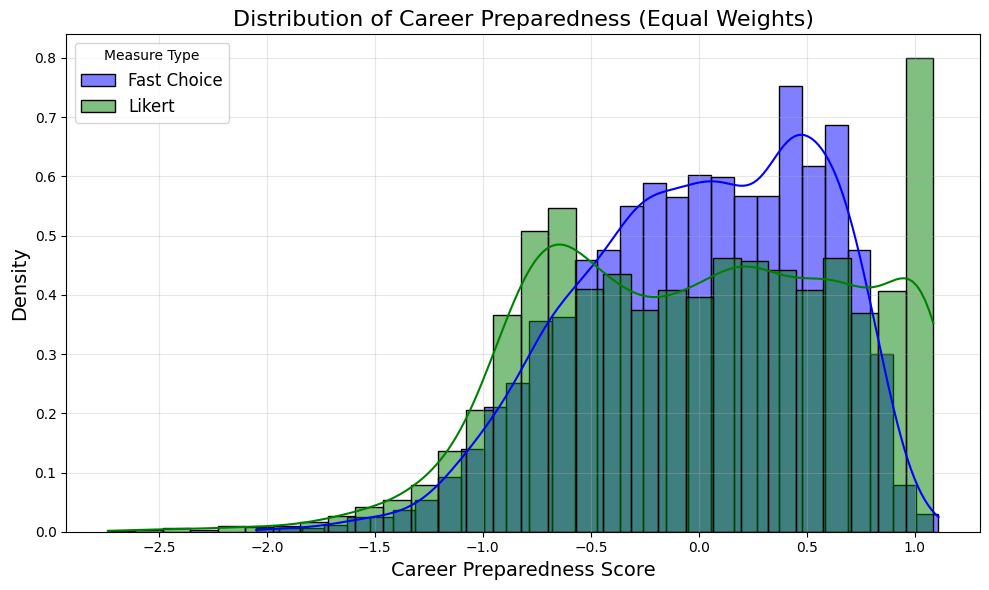

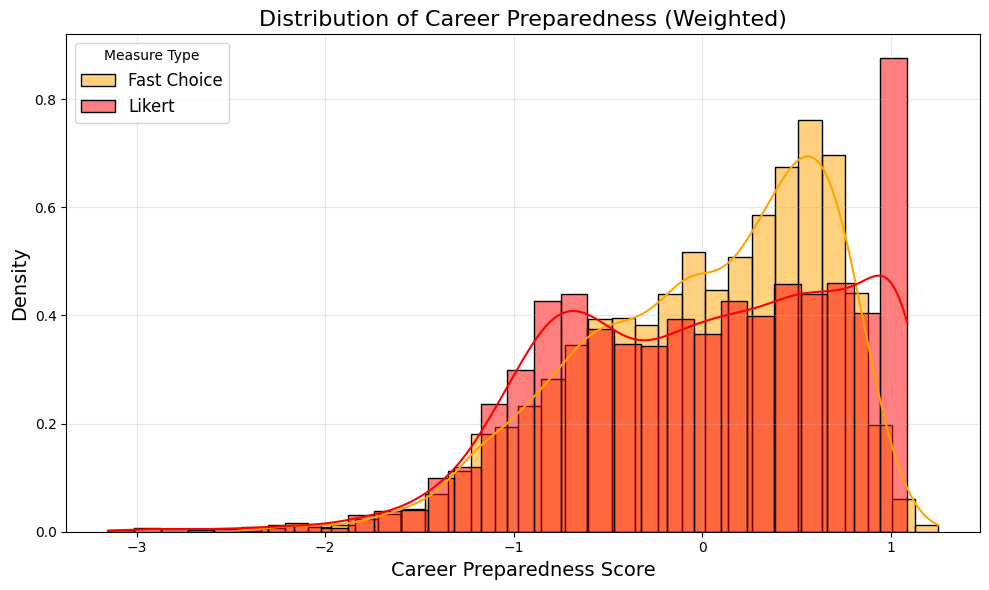

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Equal Weights
plt.figure(figsize=(10, 6))
sns.histplot(data_with_preparedness['career_preparedness_ew_fast'], kde=True, color='blue', label='Fast Choice', stat='density', bins=30)
sns.histplot(data_with_preparedness['career_preparedness_ew_likert'], kde=True, color='green', label='Likert', stat='density', bins=30)
plt.title('Distribution of Career Preparedness (Equal Weights)', fontsize=16)
plt.xlabel('Career Preparedness Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Measure Type', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Weighted
plt.figure(figsize=(10, 6))
sns.histplot(data_with_preparedness['career_preparedness_w_fast'], kde=True, color='orange', label='Fast Choice', stat='density', bins=30)
sns.histplot(data_with_preparedness['career_preparedness_w_likert'], kde=True, color='red', label='Likert', stat='density', bins=30)
plt.title('Distribution of Career Preparedness (Weighted)', fontsize=16)
plt.xlabel('Career Preparedness Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Measure Type', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()